### 1.4
#### a.)
First, we have 
$$
y = X\beta + \epsilon, \epsilon \sim N(0, \Sigma) \implies y\sim (X\beta, \Sigma).
$$
Second, we perform the standard procedure when taking $Ax$ for $x\sim N(\mu, \Omega)$, i.e.
$$
Ax \sim N(A\mu, A\Omega A^T),
$$
which gives
$$
\Sigma^{-1/2}y \sim N(\Sigma^{-1/2}X\beta, (\Sigma^{-1/2}\Sigma(\Sigma^{-1/2})^T) = N(\Sigma^{-1/2}X\beta, I_n) = \Sigma^{-1/2}X\beta + N(0, I_n),
$$
as desired.

#### b.)

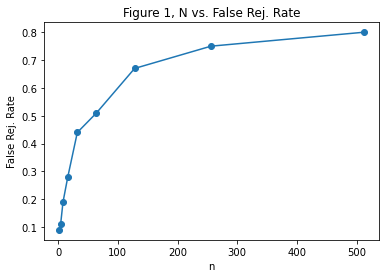

,N,false_rej_rate
0,2,0.09
1,4,0.11
2,8,0.19
3,16,0.28
4,32,0.44
5,64,0.51
6,128,0.67
7,256,0.75
8,512,0.80


In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

norm = scipy.stats.norm
mvnorm = scipy.stats.multivariate_normal
F = scipy.stats.f

RHO = .1

def generate_data(n, cov_matrix, mu=0., alpha=0., **kwargs):
    """
    Generates data according to 2.4b.
    """
    return mvnorm(np.zeros(n) + alpha, cov_matrix).rvs(**kwargs)

def do_anova(n, seed_1, seed_2, sigma2=1., correct_f=False, **kwargs):
    """
    Generates data for, and performs a single ANOVA test
    """
    cov_matrix = (
        sigma2 * (1 - RHO) * np.eye(n) + 
        sigma2 * RHO * np.ones((n, n))
    )
    
    y1 = generate_data(n=n, cov_matrix=cov_matrix, random_state=seed_1)
    y2 = generate_data(n=n, cov_matrix=cov_matrix, random_state=seed_2)

    sn_2 = 1/(2 * n - 2) * (
        (y1 - np.mean(y1)).T @ (y1 - np.mean(y1)) +
        (y2 - np.mean(y2)).T @ (y2 - np.mean(y2))
    )

    f_stat = n/2 * (np.mean(y1) - np.mean(y2)) ** 2
    f_stat = f_stat / sn_2
    
    if correct_f:
        sigma2_hat = (1 / (2 * n ** 2)) * np.sum(np.power(y1[:, None] - y2.T[None, :], 2))
        rho_hat = 1 - sn_2 / sigma2_hat
        rho_hat = 0 if rho_hat < 0 else rho_hat
        f_stat = (1 - rho_hat) / (1 - rho_hat + rho_hat * n) * f_stat
    pval = 1 - F(1, 2 * n - 2).cdf(f_stat)
    return pval


def do_anova_repeated(n, nsim=100, **kwargs):
    """
    Does ANOVA procedure over multiple passes
    """
    np.random.seed(20)
    seeds_y1 = np.random.choice(nsim*10, nsim)
    np.random.seed(21)
    seeds_y2 = np.random.choice(nsim*10, nsim)
    result = np.array([
        do_anova(n, seed_1=s1, seed_2=s2, **kwargs) 
        for (s1, s2) in list(zip(seeds_y1, seeds_y2))
    ])
    return result


def main_4(n_seq = 2 ** np.array(range(1, 10)), correct_f=False): # 1, 10
    result = np.stack([
        do_anova_repeated(n, nsim=100, correct_f=correct_f)
        for n in n_seq
    ])
    # compute false rejections
    false_rej_rate = np.mean(result < .05, axis=1)
    # plot it 
    plt.plot(n_seq, false_rej_rate)
    plt.scatter(n_seq, false_rej_rate)
    plt.xlabel("n")
    plt.ylabel("False Rej. Rate")
    plt.title("Figure 1, N vs. False Rej. Rate")
    plt.show()
    # show table of false rejections
    return pd.DataFrame({
        "N": n_seq,
        "false_rej_rate": false_rej_rate
    })
    
main_4()

As expected, the rejection rate increases as $n$ increases, due to a leading coefficient $\propto (1 - \rho + rho n)$ -- this behavior is detailed in problem 3f. 

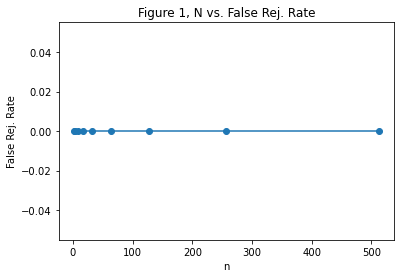

,N,false_rej_rate
0,2,0.0
1,4,0.0
2,8,0.0
3,16,0.0
4,32,0.0
5,64,0.0
6,128,0.0
7,256,0.0
8,512,0.0


In [2]:
main_4(correct_f=True)

Under the correction, we see zero rejections -- implying that the correction was too conservative and pulled $F$ too far back. Indeed, as detailed on Ed, this was the case, due to an erroneously-posed correction term for the $\hat F$ statistic. 